# How to Thrust 

In [ ]:
import pycuda.autoinit, pycuda.driver

from pycuda.compiler import SourceModule

import numpy

import time





mod = SourceModule('''

#include <thrust/random.h>
#include <thrust/copy.h>
#include <thrust/execution_policy.h>


extern "C" {



__global__ void test_rand(int numRand, float *samples)

{

  int threadID = blockIdx.x * gridDim.x + threadIdx.x;

  thrust::default_random_engine rng;

  rng.discard(numRand * threadID);



  thrust::uniform_real_distribution<float> rand01(0,1);



  float acc=0.0;

  for (int i=0; i < numRand; i++) {

	float r = rand01(rng);

	acc += r;

  }

  thrust::copy(thrust::device, samples, samples +2, samples + 3);

  samples[threadID] = acc/numRand;  // Normalize back to range [0,1)

}



}

''', no_extern_c=True)



test_rand = mod.get_function('test_rand')



### Compute many sums of random numbers

numRand = 512

threads_per_block = 256

blocks = 512

threads = threads_per_block * blocks

print('Sampling sum of', numRand, 'random numbers', threads, 'times.')

samples = numpy.zeros(threads, dtype=numpy.float32)



start = time.time()

test_rand(numpy.int32(numRand), pycuda.driver.Out(samples), grid=(blocks,1), block=(threads_per_block,1,1))

stop = time.time()

print('Execution+copy time = %1.1f msec' % ( (stop-start) * 1000.0,))



### Look at results in a lame text-only way

### Squint hard!  Central Limit Theorem says this is approximately a Gaussian.

hist, bin_edges = numpy.histogram(samples, bins=20, range=(0.3, 0.7))

print('Distribution:', hist)

## How to PyCuda 


In [11]:
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
import numpy
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
import pycuda.cumath
from pycuda.elementwise import ElementwiseKernel

In [ ]:
import os
os.environ["PATH"] = "/usr/local/sbin:/usr/local/bin:/usr/sbin:/sbin:/bin:/usr/local/cuda-7.5/bin:/usr/local/cuda-7.5"

In [ ]:
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-7.5/lib64"

In [ ]:
inc_2d = mod.get_function("inc_2d")
# create an array of 1s
# blockspergrid
# threadsperblock
start.record() # start timing
st = time()
inc_2d(drv.Out(an_array), numpy.int32(an_array.shape[0]), 
                   grid=(blockspergrid,), block= (threadsperblock,1,1))
print("Calc time ", time()-st)
end.record() # end timing
# calculate the run length
end.synchronize()
secs = start.time_till(end)*1e-3
print("C++ CUDA time:")
print("%fs" % secs)

In [ ]:
# create two timers so we can speed-test each approach
start = drv.Event()
end = drv.Event()

######################
# SourceModele SECTION
# We write the C code and the indexing and we have lots of control

mod = SourceModule("""
__global__ void do_work(int* dest, int n1)
{
    const int i = blockDim.x*blockIdx.x + threadIdx.x;
      if (i < n1)
          dest[i] += 1;
}

__global__ void inc_2d(int* dest, int n1)
{
  const int i = blockDim.x*blockIdx.x + threadIdx.x;
  if (threadIdx.x == 0) {
        do_work<<<1, 32>>>(dest, n1);
        cudaThreadSynchronize();
    }
 __syncthreads();
}
""")

## Numba CUDA 

In [ ]:
@cuda.jit
def increment_a_2D_array(an_array):
    x = cuda.grid(1)
    if x < an_array.shape[0]:
        an_array[x] += 1

In [ ]:
threadsperblock = 4
blockspergrid_x = math.ceil(an_array.shape[0] / threadsperblock)
#blockspergrid_y = math.ceil(an_array.shape[1] / threadsperblock[1])
blockspergrid = blockspergrid_x # , blockspergrid_y)
start = time()
increment_a_2D_array[blockspergrid, threadsperblock](an_array)
print("Numba time CUDA ", time()-start)

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [13]:
import numba

ValueError: bad marshal data (unknown type code)

In [14]:
from numba import cuda

ValueError: bad marshal data (invalid reference)

In [ ]:
import sys
print(sys.path)

In [ ]:
sys.path.append('/usr/local/cuda-7.5/bin')
sys.path.append('/usr/local/cuda-7.5/lib')

In [ ]:
print(sys.path)

In [ ]:

from accelerate.cuda.blas import Blas
import numpy as np
from timeit import default_timer as timer

N = 128     # no. of rows/cols

def gemm_v1():
    '''
    Note that all arrays are in Fortran order.
    '''
    print("Version 1".center(80, '='))
    # Prepare arrays for input
    A = np.array(np.arange(N ** 2, dtype=np.float32).reshape(N, N), order='F')
    B = np.array(np.arange(N) + 10, dtype=A.dtype, order='F')
    D = np.zeros_like(A, order='F')

    # NumPy
    start = timer()
    E = np.dot(A, np.diag(B))
    numpy_time = timer() - start
    print("Numpy took %f seconds" % numpy_time)

    # cuBLAS
    blas = Blas()

    start = timer()
    blas.gemm('N', 'N', N, N, N, 1.0, A, np.diag(B), 1.0, D)
    cuda_time = timer() - start

    print("CUBLAS took %f seconds" % cuda_time)
    diff = np.abs(D - E)
    print("Maximum error %f" % np.max(diff))


def gemm_v2():
    """
    Let GEMM transpose the input matrices so that they can be in C order,
    originally.  Note that the output matrix is still in Fortran array.
    The string arguments in gemm tells it to apply transformation on the input
    matrices.
    See argument description in:
        http://docs.continuum.io/accelerate/cublas#blas-level-2
    """
    print("Version 2".center(80, '='))
    # Prepare arrays for input
    A = np.array(np.arange(N ** 2, dtype=np.float32).reshape(N, N))
    B = np.array(np.arange(N) + 10, dtype=A.dtype)
    D = np.zeros_like(A, order='F')

    # NumPy
    start = timer()
    E = np.dot(A, np.diag(B))
    numpy_time = timer() - start
    print("Numpy took %f seconds" % numpy_time)

    # cuBLAS
    blas = Blas()

    start = timer()
    blas.gemm('T', 'T', N, N, N, 1.0, A, np.diag(B), 1.0, D)
    cuda_time = timer() - start

    print("CUBLAS took %f seconds" % cuda_time)
    diff = np.abs(D - E)
    print("Maximum error %f" % np.max(diff))



gemm_v1()
gemm_v2()



In [ ]:
from pycuda.driver import get_version
print(get_version())


In [ ]:
import os
os.environ["PATH"] = "/usr/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/sbin:/bin:/usr/local/cuda-7.5/bin:/usr/local/cuda-7.5"

In [ ]:
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-7.5/lib64"

In [ ]:
os.environ["PATH"] = "$PATH:/usr/bin"

In [ ]:
alias show echo

In [ ]:
show $PATH

In [ ]:
# SimpleSpeedTest.py

# Very simple speed testing code
# Shows you how to run a loop over sin() using different methods
# with a note of the time each method takes
# For the GPU this uses SourceModule, ElementwiseKernel, GPUArray
# For the CPU this uses numpy
# Ian@IanOzsvald.com

# Using a WinXP Intel Core2 Duo 2.66GHz CPU (1 CPU used)
# with a 9800GT GPU I get the following timings (smaller is better):
#
# Using nbr_values == 8192
# Calculating 100000 iterations
# SourceModule time and first three results:
# 0.166590s, [ 0.005477  0.005477  0.005477]
# Elementwise time and first three results:
# 0.171657s, [ 0.005477  0.005477  0.005477]
# Elementwise Python looping time and first three results:
# 1.487470s, [ 0.005477  0.005477  0.005477]
# GPUArray time and first three results:
# 4.740007s, [ 0.005477  0.005477  0.005477]
# CPU time and first three results:
# 32.933660s, [ 0.005477  0.005477  0.005477]
#
# 
# Using Win 7 x64, GTX 470 GPU, X5650 Xeon,
# Driver v301.42, CUDA 4.2, Python 2.7 x64,
# PyCuda 2012.1 gave the following results:
#
# Using nbr_values == 8192
# Calculating 100000 iterations
# SourceModule time and first three results:
# 0.058321s, [ 0.005477  0.005477  0.005477]
# Elementwise time and first three results:
# 0.102110s, [ 0.005477  0.005477  0.005477]
# Elementwise Python looping time and first three results:
# 2.428810s, [ 0.005477  0.005477  0.005477]
# GPUArray time and first three results:
# 8.421861s, [ 0.005477  0.005477  0.005477]
# CPU time measured using :
# 5.905661s, [ 0.005477  0.005477  0.005477]


import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
import numpy
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
import pycuda.cumath
from pycuda.elementwise import ElementwiseKernel

blocks = 64
block_size = 128
nbr_values = blocks * block_size

print("Using nbr_values ==", nbr_values)

# Number of iterations for the calculations,
# 100 is very quick, 2000000 will take a while
n_iter = 100000
print("Calculating %d iterations" % (n_iter))

# create two timers so we can speed-test each approach
start = drv.Event()
end = drv.Event()

######################
# SourceModele SECTION
# We write the C code and the indexing and we have lots of control

mod = SourceModule("""
__global__ void gpusin(float *dest, float *a, int n_iter)
{
  const int i = blockDim.x*blockIdx.x + threadIdx.x;
  for(int n = 0; n < n_iter; n++) {
    a[i] = sin(a[i]);
  }
  dest[i] = a[i];
}
""")

gpusin = mod.get_function("gpusin")

# create an array of 1s
a = numpy.ones(nbr_values).astype(numpy.float32)
# create a destination array that will receive the result
dest = numpy.zeros_like(a)

start.record() # start timing
gpusin(drv.Out(dest), drv.In(a), numpy.int32(n_iter), grid=(blocks,1), block=(block_size,1,1) )
end.record() # end timing
# calculate the run length
end.synchronize()
secs = start.time_till(end)*1e-3
print("SourceModule time and first three results:")
print("%fs, %s" % (secs, str(dest[:3])))


#####################
# Elementwise SECTION
# use an ElementwiseKernel with sin in a for loop all in C call from Python
kernel = ElementwiseKernel(
   "float *a, int n_iter",
   "for(int n = 0; n < n_iter; n++) { a[i] = sin(a[i]);}",
   "gpusin")

a = numpy.ones(nbr_values).astype(numpy.float32)
a_gpu = gpuarray.to_gpu(a)
start.record() # start timing
kernel(a_gpu, numpy.int(n_iter))
end.record() # end timing
    # calculate the run length
    end.synchronize()
    secs = start.time_till(end)*1e-3
    print("Elementwise time and first three results:")
    print("%fs, %s" % (secs, str(a_gpu.get()[:3])))


    ####################################
    # Elementwise Python looping SECTION
    # as Elementwise but the for loop is in Python, not in C
    kernel = ElementwiseKernel(
       "float *a",
       "a[i] = sin(a[i]);",
       "gpusin")

a = numpy.ones(nbr_values).astype(numpy.float32)
a_gpu = gpuarray.to_gpu(a)
start.record() # start timing
for i in range(n_iter):
    kernel(a_gpu)
end.record() # end timing
# calculate the run length
end.synchronize()
secs = start.time_till(end)*1e-3
print("Elementwise Python looping time and first three results:")
print("%fs, %s" % (secs, str(a_gpu.get()[:3])))


##################
# GPUArray SECTION
# The result is copied back to main memory on each iteration, this is a bottleneck

a = numpy.ones(nbr_values).astype(numpy.float32)
a_gpu = gpuarray.to_gpu(a)
start.record() # start timing
for i in range(n_iter):
    a_gpu = pycuda.cumath.sin(a_gpu)
end.record() # end timing
# calculate the run length
end.synchronize()
secs = start.time_till(end)*1e-3
print("GPUArray time and first three results:")
print("%fs, %s" % (secs, str(a_gpu.get()[:3])))


#############
# CPU SECTION
# use numpy the calculate the result on the CPU for reference

a = numpy.ones(nbr_values).astype(numpy.float32)
start.record() # start timing
start.synchronize()

for i in range(n_iter):
    a = numpy.sin(a)

end.record() # end timing
# calculate the run length
end.synchronize()
secs = start.time_till(end)*1e-3
print("CPU time and first three results:")
print("%fs, %s" % (secs, str(a[:3])))

In [ ]:
alias export sets

In [ ]:
LD_LIBRARY_PATH='/usr/local/cuda-7.5/lib'

In [ ]:
export LD_LIBRARY_PATH

In [ ]:
PATH='/usr/local/cuda-7.5/bin:$PATH'

In [ ]:
export PATH

In [ ]:
import os
os.system('export LD_LIBRARY_PATH=/usr/local/cuda-7.5/lib64:$LD_LIBRARY_PATH')

In [ ]:
from jupyter import jupyter_core as j
jupyter_path()


In [ ]:
from jupyter_core.paths import jupyter_data_dir, jupyter_path, ENV_JUPYTER_PATH




In [ ]:
jupyter_path('nvcc')

In [ ]:
PATH='$PATH:/usr/local/cuda-7.5/bin'

In [ ]:
show $PATH

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
from nxpd import draw


In [4]:
G=nx.path_graph(30)


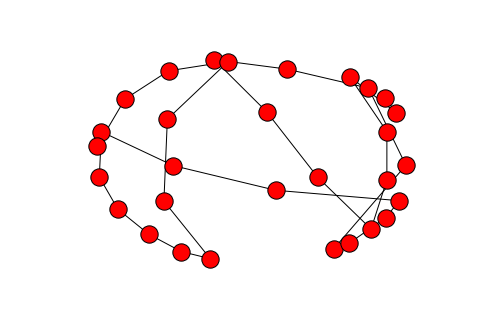

In [5]:
nx.draw(G)

In [6]:
def make_annotations(pos, text, font_size=14, font_color='rgb(25,25,25)'):
    L=len(pos)
    if len(text)!=L:
        raise ValueError('The lists pos and text must have the same len')
    annotations = Annotations()
    for k in range(L):
        annotations.append(
            Annotation(
                text=text[k], 
                x=pos[k][0], y=pos[k][1],
                xref='x1', yref='y1',
                font=dict(color= font_color, size=font_size),
                showarrow=False)
        )
    return annotations 

In [7]:
import plotly.plotly as py
from plotly.graph_objs import *

In [8]:
def scatter_nodes(pos, labels=None, color=None, size=20, opacity=1):
    # pos is the dict of node positions
    # labels is a list  of labels of len(pos), to be displayed when hovering the mouse over the nodes
    # color is the color for nodes. When it is set as None the Plotly default color is used
    # size is the size of the dots representing the nodes
    #opacity is a value between [0,1] defining the node color opacity
    L=len(pos)
    trace = Scatter(x=[], y=[],  mode='markers', marker=Marker(size=[]))
    for k in range(L):
        trace['x'].append(pos[k][0])
        trace['y'].append(pos[k][1])
    attrib=dict(name='', text=labels , hoverinfo='text', opacity=opacity) # a dict of Plotly node attributes
    trace=dict(trace, **attrib)# concatenate the dict trace and attrib
    trace['marker']['size']=size
    return trace  

In [9]:
def scatter_edges(G, pos, line_color=None, line_width=1):
    trace = Scatter(x=[], y=[], mode='lines')
    for edge in G.edges():
        trace['x'] += [pos[edge[0]][0],pos[edge[1]][0], None]
        trace['y'] += [pos[edge[0]][1],pos[edge[1]][1], None]  
        trace['hoverinfo']='none'
        trace['line']['width']=line_width
        if line_color is not None: # when it is None a default Plotly color is used
            trace['line']['color']=line_color
    return trace   

In [10]:
pos=nx.fruchterman_reingold_layout(G) 

In [11]:
labels=[str(k)  for k in range(len(pos))] # labels are  set as being the nodes indices in the list of nodes
trace1=scatter_edges(G, pos)
trace2=scatter_nodes(pos, labels=labels)

In [12]:
width=500
height=500
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=Layout(title= 'Fruchterman Reingold  layout',  #
    font= Font(),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=XAxis(axis),
    yaxis=YAxis(axis),
    margin=Margin(
        l=40,
        r=40,
        b=85,
        t=100,
        pad=0,
       
    ),
    hovermode='closest',
    plot_bgcolor='#EFECEA', #set background color            
    )


data=Data([trace1, trace2])

fig = Figure(data=data, layout=layout)

In [14]:
fig['layout'].update(annotations=make_annotations(pos, [str(k) for k in range(len(pos))]))  
#py.sign_in('grimadas', 'd5zhcwt2aw')
py.iplot(fig, filename='tst')

In [ ]:
f = open(file_name, "r")
n, self.m = [int(x) for x in f.readline().split()] # read first line
# add nodes
for i in range(1, self.n+1):
         g.add_node(i)
# add edges 
degrees = [0 for i in range(0, self.n+1)]   

In [ ]:
from numba import cuda

In [ ]:
@cuda.jit("(uint64[:], uint64)", device=True)
def cuda_xorshiftstar(states, id):
    x = states[id]
    x ^= x >> 12
    x ^= x << 25
    x ^= x >> 27
    states[id] = x
    return uint64(x) * uint64(2685821657736338717)

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from(
    [('A', 'B'), ('A', 'C'), ('D', 'B'), ('E', 'C'), ('E', 'F'),
     ('B', 'H'), ('B', 'G'), ('B', 'F'), ('C', 'G')])

val_map = {'A': 1.0,
           'D': 0.5714285714285714,
           'H': 0.0}

values = [val_map.get(node, 0.25) for node in G.nodes()]

# Specify the edges you want here
red_edges = [('A', 'C'), ('E', 'C')]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_color = values)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
plt.show()

In [ ]:
import jgraph

jgraph.draw([(1, 2), (2, 3), (3, 4), (4, 1), (4, 5), (5, 2)])


In [ ]:
#!/usr/bin/env python
"""
Draw a graph with matplotlib.
You must have matplotlib for this to work.
"""
import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    raise

import networkx as nx
#matplotlib.use('Agg')
G=nx.path_graph(8)
nx.draw(G, with_labels=True)
plt.savefig("simple_path.png") # save as png
plt.show() # display

In [ ]:
import random
import pylab
from matplotlib.pyplot import pause
import networkx as nx
pylab.ion()

graph = nx.Graph()
node_number = 0
graph.add_node(node_number, Position=(random.randrange(0, 100), random.randrange(0, 100)))

def get_fig():
    global node_number
    node_number += 1
    graph.add_node(node_number, Position=(random.randrange(0, 100), random.randrange(0, 100)))
    graph.add_edge(node_number, random.choice(graph.nodes()))
    fig = pylab.figure()
    nx.draw(graph, pos=nx.get_node_attributes(graph,'Position'))
    return fig

num_plots = 50;
pylab.show()

for i in range(num_plots):

    fig = get_fig()
    fig.canvas.draw()
    pylab.draw()

    pylab.close(fig)

In [ ]:
import random
import pylab
from matplotlib.pyplot import pause
import networkx as nx
pylab.ion()

graph = nx.Graph()
node_number = 0
graph.add_node(node_number, Position=(random.randrange(0, 100), random.randrange(0, 100)))

def get_fig():
    global node_number
    node_number += 1
    graph.add_node(node_number, Position=(random.randrange(0, 100), random.randrange(0, 100)))
    graph.add_edge(node_number, random.choice(graph.nodes()))
    nx.draw(graph, pos=nx.get_node_attributes(graph,'Position'))

num_plots = 50;
pylab.show()

for i in range(num_plots):

    get_fig()
    pause(1)
    pylab.draw()
    

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import wx
from matplotlib.backends.backend_wxagg import \
FigureCanvasWxAgg as FigCanvas, \
NavigationToolbar2WxAgg as NavigationToolbar

class NetworkFrame(wx.Frame):

    def __init__(self):
        wx.Frame.__init__(self, None, -1)
        self.panel = wx.Panel(self)
        self.fig = plt.figure()
        self.canvas = FigCanvas(self.panel, -1, self.fig)
        G=nx.house_graph()
    pos={0:(0,0),
        1:(1,0),
        2:(0,1),
        3:(1,1),
        4:(0.5,2.0)}

nx.draw_networkx_nodes(G,pos,node_size=2000,nodelist=[4])
nx.draw_networkx_nodes(G,pos,node_size=3000,nodelist=[0,1,2,3],node_color='b')
nx.draw_networkx_edges(G,pos,alpha=0.5,width=6)
plt.axis('off')
self.vbox = wx.BoxSizer(wx.VERTICAL)
    self.vbox.Add(self.canvas, 1, wx.LEFT | wx.TOP | wx.GROW)
    self.toolbar = NavigationToolbar(self.canvas)
    self.vbox.Add(self.toolbar, 0, wx.EXPAND)
    self.panel.SetSizer(self.vbox)
    self.vbox.Fit(self)


#plt.savefig("house_with_colors.png") # save as png
#plt.show() # display

app = wx.PySimpleApp()
app.frame = NetworkFrame()
app.frame.Show()
app.MainLoop()

In [ ]:
from ipywidgets import widgets

In [ ]:
%pylab inline
%matplotlib notebook

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from networkx.drawing.nx_agraph import graphviz_layout
from nxpd import draw
from matplotlib import animation

G = nx.Graph()
#G.add_edges_from([(0,1),(1,2),(2,0)])
fig = plt.figure(figsize=(8,8))

nc = np.random.random(3)

def init():
    G.add_edges_from([(0,1),(1,2),(2,0)])
    return G,


# animation function.  This is called sequentially
k = 0

def animate(i):
    global k
    G.add_edge(1, i)
    k += 1
    pos = graphviz_layout(G)
    nx.draw(G, pos)
    print(k)
    return G,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=4, interval=20, blit=True)


In [ ]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)


In [1]:
import plotly.plotly as py
from plotly.graph_objs import *

trace0 = Scatter(
  x=[1, 2, 3, 4],
  y=[10, 15, 13, 17]
)
trace1 = Scatter(
  x=[1, 2, 3, 4],
  y=[16, 5, 11, 9]
)
data = Data([trace0, trace1])

py.iplot(data, filename = 'basic-line')

ValueError: bad marshal data (invalid reference)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.plotly as py

n = 50
x, y, z, s, ew = np.random.rand(5, n)
c, ec = np.random.rand(2, n, 4)
area_scale, width_scale = 500, 5

fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=c,
                s=np.square(s)*area_scale,
                edgecolor=ec,
                linewidth=ew*width_scale)
ax.grid()

py.iplot_mpl(fig)

In [ ]:
# JS Animation import is available at http://github.com/jakevdp/JSAnimation
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

# Set up the axes, making sure the axis ratio is equal
fig = plt.figure(figsize=(6.5, 2.5))
ax = fig.add_axes([0, 0, 1, 1], xlim=(-0.02, 13.02), ylim=(-0.02, 5.02),
                  xticks=range(14), yticks=range(6), aspect='equal', frameon=False)
ax.grid(True)

# Define the shapes of the polygons
P1 = np.array([[0, 0], [5, 0], [5, 2], [0, 0]])
P2 = np.array([[0, 0], [8, 0], [8, 3], [0, 0]])
P3 = np.array([[0, 0], [5, 0], [5, 1], [3, 1], [3, 2], [0, 2], [0, 0]])
P4 = np.array([[0, 1], [3, 1], [3, 0], [5, 0], [5, 2], [0, 2], [0, 1]])

# Draw the empty polygons for the animation
kwds = dict(ec='k', alpha=0.5)
patches = [ax.add_patch(plt.Polygon(0 * P1, fc='g', **kwds)),
           ax.add_patch(plt.Polygon(0 * P2, fc='b', **kwds)),
           ax.add_patch(plt.Polygon(0 * P3, fc='y', **kwds)),
           ax.add_patch(plt.Polygon(0 * P4, fc='r', **kwds))]

# This function moves the polygons as a function of the frame i
Nframes = 30
def animate(nframe):
    f = nframe / (Nframes - 1.0)
    patches[0].set_xy(P1 + (8 - 8 * f, 3 - 3 * f + 0.5 * np.sin(f * np.pi)))
    patches[1].set_xy(P2 + (5 * f, 2 * f - 0.5 * np.sin(f * np.pi)))
    patches[2].set_xy(P3 + (8 - 3 * f, 0))
    patches[3].set_xy(P4 + (8, 1 - f))
    return patches
    
anim = animation.FuncAnimation(fig, animate, frames=Nframes, interval=50)
display_animation(anim, default_mode='once')

In [1]:
from __future__ import print_function

import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import pycuda.driver as drv
import numpy as np

import skcuda.linalg as culinalg
import skcuda.misc as cumisc
culinalg.init()

# Double precision is only supported by devices with compute
# capability >= 1.3:
import string
demo_types = [np.float32, np.complex64]
if cumisc.get_compute_capability(pycuda.autoinit.device) >= 1.3:
    demo_types.extend([np.float64, np.complex128])

for t in demo_types:
    print('Testing matrix multiplication for type ' + str(np.dtype(t)))
    if np.iscomplexobj(t()):
        a = np.asarray(np.random.rand(10, 5) + 1j * np.random.rand(10, 5), t)
        b = np.asarray(np.random.rand(5, 5) + 1j * np.random.rand(5, 5), t)
        c = np.asarray(np.random.rand(5, 5) + 1j * np.random.rand(5, 5), t)
    else:
        a = np.asarray(np.random.rand(10, 5), t)
        b = np.asarray(np.random.rand(5, 5), t)
        c = np.asarray(np.random.rand(5, 5), t)

    a_gpu = gpuarray.to_gpu(a)
    b_gpu = gpuarray.to_gpu(b)
    c_gpu = gpuarray.to_gpu(c)

    temp_gpu = culinalg.dot(a_gpu, b_gpu)
    d_gpu = culinalg.dot(temp_gpu, c_gpu)
    temp_gpu.gpudata.free()
    del(temp_gpu)
    print('Success status: ', np.allclose(np.dot(np.dot(a, b), c), d_gpu.get()))

    print('Testing vector multiplication for type ' + str(np.dtype(t)))
    if np.iscomplexobj(t()):
        d = np.asarray(np.random.rand(5) + 1j * np.random.rand(5), t)
        e = np.asarray(np.random.rand(5) + 1j * np.random.rand(5), t)
    else:
        d = np.asarray(np.random.rand(5), t)
        e = np.asarray(np.random.rand(5), t)

    d_gpu = gpuarray.to_gpu(d)
    e_gpu = gpuarray.to_gpu(e)

    temp = culinalg.dot(d_gpu, e_gpu)
    print('Success status: ', np.allclose(np.dot(d, e), temp))

Testing matrix multiplication for type float32
Success status:  True
Testing vector multiplication for type float32
Success status:  True
Testing matrix multiplication for type complex64
Success status:  True
Testing vector multiplication for type complex64
Success status:  True
Testing matrix multiplication for type float64
Success status:  True
Testing vector multiplication for type float64
Success status:  True
Testing matrix multiplication for type complex128
Success status:  True
Testing vector multiplication for type complex128
Success status:  True
